In [1]:
import openmc
import numpy as np
import time
import csv
import openmc.deplete

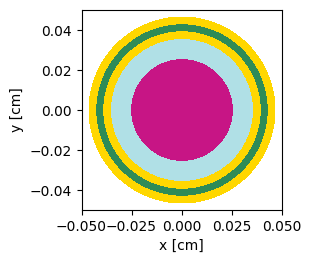

In [2]:
#mats taken from openmc triso example https://github.com/openmc-dev/openmc/wiki/Example-Jupyter-Notebooks

#TRISO fuel specific
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.5)

#below compositions will need to be adjusted as this is for fresh fuel
fuel.add_nuclide('U235', 0.04/7, percent_type = 'wo')
fuel.add_nuclide('U236', 0.015/7, percent_type = 'wo')
fuel.add_nuclide('Pu239',  0.048/7, percent_type = 'wo')
fuel.volume = 65.44984692 #in cm3

#need to add buffer layer:
Buffer = openmc.Material(name='Buffer')
Buffer.set_density('g/cm3', 1.02)
Buffer.add_element('C', 1.0)
Buffer.add_s_alpha_beta('c_Graphite')
t_Buffer = 0.01 #thickeness of buffer layer

#adding the PyC layer
PyC = openmc.Material(name='PyC1')
PyC.set_density('g/cm3', 1.92)
PyC.add_element('C', 1.0)
PyC.add_s_alpha_beta('c_Graphite')
tiPyC = 0.0039 #thickness of inner PyC
toPyC = tiPyC

#adding the SiC layer
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)
tSic = 0.0035 #thickness of SiC

#outer pebble material
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.7) #A3-3 Graphite
graphite.add_element('C', 1.0) 
graphite.add_s_alpha_beta('c_Graphite')


#cask fill insert, may also be helium
air = openmc.Material(name='air')
air.set_density('atom/b-cm', 0.0006) #'atom/b-cm', 0.0006
air.add_element('N',0.78)
air.add_element('O',0.21)
air.add_element('Ar',0.01)


#cask materials 

#inner cask
SS304 = openmc.Material(name = 'SS304')
SS304.set_density('g/cm3',7.93)
SS304.add_element('C',0.08/100,'wo')
SS304.add_element('P',0.045/100,'wo')
SS304.add_element('Si',0.75/100, 'wo')
SS304.add_element('Ni',13.5/100, 'wo')
SS304.add_element('N',0.1/100,'wo')
SS304.add_element('Mn',2/100, 'wo')
SS304.add_element('S',0.03/100,'wo')
SS304.add_element('Cr',19/100,'wo')
SS304.add_element('B',2.250/100,'wo')
SS304.add_element('Fe',62.245/100,'wo')
t_ss = 2 #cm

#concrete
conc = openmc.Material(name = 'conc')
conc.set_density('g/cm3',2.43)
conc.add_element('H',1,'wo')
#need to use mix materials to design this shielding cask 
#need a new method to approach the composition of dense concrete
t_conc = 20 #cm

#XM-19
xm19 = openmc.Material(name = 'xm19')
xm19.set_density('g/cm3',7.88)
xm19.add_element('Cr',22/100,'wo')
xm19.add_element('Ni',12.5/100,'wo')
xm19.add_element('Mn',5/100,'wo')
xm19.add_element('Mo',2.25/100,'wo')
xm19.add_element('Si',1/100,'wo')
xm19.add_element('N',0.3/100,'wo')
xm19.add_element('Nb',0.2/100,'wo')
xm19.add_element('P',0.2/100,'wo')
xm19.add_element('C',0.06/100,'wo')
xm19.add_element('S',0.01/100,'wo')
xm19.add_element('Fe',56.48/100,'wo')
t_xm19 = 10 #cm


#in centimeters (assuming it to be, looking at above units), need to check this with ZOE
#fuel pebble dimensions
peb_or = 3 #non-fuel portion
peb_ir = 2.5 #fuel portion

#TRISO particle dimensions
kernel_or = 0.02545 #radius of fuel kernel
buffer_r = kernel_or + t_Buffer
ipyc_r = buffer_r + tiPyC
sic_r = ipyc_r + tSic
opyc_r = sic_r + tiPyC #should be around 0.0455 cm, it is 0.04675

#core (cask) dimensions 
core_r = 0.5*100
core_h = 4.16*100

#more defining of our triso particles, all code below for developing our TRISO particles
kernelsph = openmc.Sphere(r=kernel_or)
buffsph = openmc.Sphere(r=buffer_r)
IPyCsph = openmc.Sphere(r=ipyc_r)
SiCsph = openmc.Sphere(r=sic_r)
OPyCsph = openmc.Sphere(r=opyc_r)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel, Buffer, PyC, SiC, PyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)
triso_colors = {triso_cells[0]: (199,21,133), triso_cells[1]: (176,224,230), 
                triso_cells[2]: (255,215,0), triso_cells[3]: (46,139,87), 
                triso_cells[4]: (255,215, 0)}
triso_universe.plot(width = (0.1, 0.1), colors = triso_colors)

#defining region to fill our fuel pebbles with!!!!!
peb_wfuel = openmc.Sphere(r=peb_ir)
peb_wfuel_outer = -peb_wfuel

centers = openmc.model.pack_spheres(opyc_r, region=peb_wfuel_outer, num_spheres = 19000 ) #saying to fill only the fuel portion of the TRISO particle
#above function will pack pebbles into a sphere, it returns an array of positions that are used in the in next line of code 
trisos = [openmc.model.TRISO(kernel_or, triso_universe, center) for center in centers] # packs pebbles based on the centers positions array 
#print(centers) #this is the positions of the TRISO pebbles themselves

In [3]:
#need to develop the geometry of our cask as a region
inner_cask = openmc.ZCylinder(r=0.5)
maxz = openmc.ZPlane(z0=core_h/2, boundary_type='white')
minz = openmc.ZPlane(z0=-core_h/2, boundary_type='white')

lattice_region = -inner_cask & -maxz & +minz

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

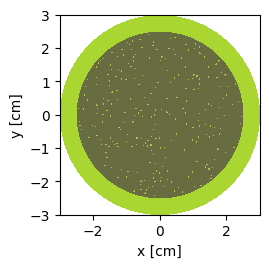

In [4]:
#generating the fuel pebbler
peb_nofuel = openmc.Sphere(r=peb_or) #generates a sphere of this radius
peb_nofuel_zone_outer = -peb_nofuel 
peb_nofuel_zone_inner = +peb_wfuel #creates a non-fuel region for our pebble
peb_fuel_zone = -peb_wfuel

sphere = openmc.Cell(region=peb_wfuel_outer) #only focusing on fuel containing portion of our fuel pebble
lower_left, upper_right = sphere.region.bounding_box
shape = (1,1,1) #Number of lattice elements in the x-, y-, and z-directions, look at the example in the repo
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)
sphere.fill = lattice

pebble_element = [sphere,
              openmc.Cell(fill=graphite, region=peb_nofuel_zone_inner & peb_nofuel_zone_outer)]
pebble_univ = openmc.Universe(cells=pebble_element)

active_core_sides = openmc.ZCylinder(r = core_r)
active_core_top = openmc.ZPlane(z0=(core_h/2))
active_core_bot = openmc.ZPlane(z0=-(core_h/2))
active_core_bound = -active_core_sides & -active_core_top & +active_core_bot
pebble_univ.plot()

In [5]:
#code to get the location data for the individual fuel pebbles!!!!!
results = []
new_row = []
with open("position for pebbles/settlephase_final_positions.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)
      
def multiply_list_by_scalar(list_of_lists, scalar):
    output = [[element * scalar for element in sub_list] for sub_list in list_of_lists]
    return output

# Example usage:
my_list = results
scalar_value = 100
multiplied_list = multiply_list_by_scalar(my_list, scalar_value)
multiplied_list[0] 

[-9.26872, -46.08, -205.00500000000002]

In [6]:
print("starting openmc pack")
start_time = time.perf_counter()
peb_centers = multiplied_list
#openmc.model.pack_spheres(peb_or, region=active_core_bound, pf = .40, contraction_rate = 0.0000001)
#need to implement this as an array of a bunch of position arrays, this might be randomly generated
print(time.perf_counter()-start_time)

pebs = [openmc.model.TRISO(peb_or, pebble_univ, peb_center) for peb_center in peb_centers] #display the locations of these pebbles using the ARFC computer
#implement our pebble locations

peb_centertest = np.vstack([peb.center for peb in pebs]) #veritically stacks the above array to easily read the positions of the pebbles
print(peb_centertest.min(axis=0))
print(peb_centertest.max(axis=0))

inner_core = openmc.Cell(region=active_core_bound)
lower_left_core, upper_right_core = inner_core.region.bounding_box
shape_core = (1,1,1)
pitch_core = (upper_right_core - lower_left_core)/shape_core
core_lattice = openmc.model.create_triso_lattice(
    pebs, lower_left_core, pitch_core, shape_core, air)

inner_core.fill=core_lattice

starting openmc pack
0.0001559469965286553
[ -47.0057  -47.0039 -205.013 ]
[ 47.0076  47.0086 199.709 ]


/home/ceserz2/anaconda3/envs/lammps-openmc/lib/python3.12/site-packages/openmc/model/triso.py:850: UserWarning: TRISO particle is partially or completely outside of the lattice.
  warnings.warn('TRISO particle is partially or completely '


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

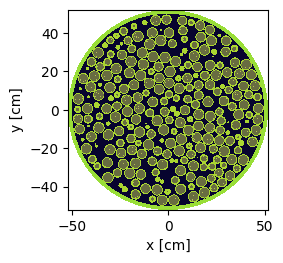

In [7]:
#AGAIN, looking at adding material surrounding the core (or our cask)

#inner cask only
inner_cask_sides = openmc.ZCylinder(r = (core_r+t_ss), boundary_type='white')
inner_cask_top = openmc.ZPlane(z0=((core_h/2)+t_ss),boundary_type='white')
inner_cask_bot = openmc.ZPlane(z0=-((core_h/2)+t_ss),boundary_type='white')
inner_cask_outer = -inner_cask_sides & -inner_cask_top & +inner_cask_bot
inner_cask_bounds = inner_cask_outer | active_core_bound
inner = openmc.Cell(region = inner_cask_bounds, fill = SS304)

#concrete shielding now!!!!
r_conc_in = core_r+t_ss
r_conc_tot = r_conc_in+t_conc
conc_sides = openmc.ZCylinder(r = r_conc_tot, boundary_type='white')
conc_top = openmc.ZPlane(z0=r_conc_tot,boundary_type='white')
conc_bot = openmc.ZPlane(z0=-r_conc_tot,boundary_type='white')
conc_outer = -conc_sides & -conc_top & +conc_bot
conc_cask_bounds = conc_outer | active_core_bound
concrete = openmc.Cell(region = conc_cask_bounds, fill = conc)

#concrete shielding now!!!!
r_xm19_in = r_conc_tot
r_xm19_tot = r_conc_tot+t_xm19
xm19_sides = openmc.ZCylinder(r = r_xm19_tot, boundary_type='white')
xm19_top = openmc.ZPlane(z0=r_xm19_tot,boundary_type='white')
xm19_bot = openmc.ZPlane(z0=-r_xm19_tot,boundary_type='white')
xm19_outer = -xm19_sides & -xm19_top & +xm19_bot
xm19_cask_bounds = xm19_outer | active_core_bound
impact = openmc.Cell(region = xm19_cask_bounds, fill = xm19)
universe = openmc.Universe(cells=[inner_core,inner]) #,concrete,impact])
universe.plot()

In [8]:
#model has been developed, time to set-up depletion
geometry = openmc.Geometry(universe)
settings = openmc.Settings()
settings.particles = 1000
settings.inactive = 10
settings.batches = 50

In [9]:
chain = openmc.deplete.Chain.from_xml("./chain_endfb71_pwr.xml")
#chain.nuclide_dict

In [14]:
model = openmc.Model(geometry=geometry, settings=settings)
op = openmc.deplete.CoupledOperator(model,"./chain_endfb71_pwr.xml")
timesteps = [122]*9
power = 0
x = openmc.deplete.CECMIntegrator(op, timesteps, power, timestep_units='d')

In [15]:
x.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/B11.h5
 Reading P31 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/P31.h5
 Reading S32 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/S32.h5
 Reading S33 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/S33.h5
 Reading S34 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/S34.h5
 Reading S36 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/S36.h5
 Reading Cr50 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cr50.h5
 Reading Cr52 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cr52.h5
 Reading Cr53 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cr53.h5
 Reading Cr54 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cr54.h5
 Reading Mn55 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mn55.h5
 Reading Fe54 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-h

 Reading Mg24 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mg24.h5
 Reading Mg25 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mg25.h5
 Reading Mg26 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mg26.h5
 Reading Al26_m1 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Al26_m1.h5
 Reading Al27 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Al27.h5
 Reading Si31 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Si31.h5
 Reading Si32 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Si32.h5
 Reading S35 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/S35.h5
 Reading Cl35 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cl35.h5
 Reading Cl36 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cl36.h5
 Reading Cl37 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cl37.h5
 Reading Ar37 from
 /home/ceserz2/xsections/endfb8

 Reading Se82 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Se82.h5
 Reading Br79 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Br79.h5
 Reading Br80 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Br80.h5
 Reading Br81 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Br81.h5
 Reading Kr78 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Kr78.h5
 Reading Kr79 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Kr79.h5
 Reading Kr80 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Kr80.h5
 Reading Kr81 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Kr81.h5
 Reading Kr82 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Kr82.h5
 Reading Kr83 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Kr83.h5
 Reading Kr84 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Kr84.h5
 Reading Kr85 from
 /home/ceserz2/xsections/endfb80/en

 Reading Mo94 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mo94.h5
 Reading Mo95 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mo95.h5
 Reading Mo96 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mo96.h5
 Reading Mo97 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mo97.h5
 Reading Mo98 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mo98.h5
 Reading Mo99 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mo99.h5
 Reading Mo100 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Mo100.h5
 Reading Tc98 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Tc98.h5


 Reading Tc99 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Tc99.h5
 Reading Ru96 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru96.h5
 Reading Ru97 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru97.h5
 Reading Ru98 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru98.h5
 Reading Ru99 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru99.h5
 Reading Ru100 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru100.h5
 Reading Ru101 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru101.h5
 Reading Ru102 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru102.h5
 Reading Ru103 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru103.h5
 Reading Ru104 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru104.h5
 Reading Ru105 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ru105.h5
 Reading Ru106 from
 /home/ceserz2/xsectio

          250K
          294K
          600K
          900K
          1200K
          2500K
          1200K
          2500K


 Reading Cd107 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd107.h5
 Reading Cd108 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd108.h5
 Reading Cd109 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd109.h5
 Reading Cd110 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd110.h5
 Reading Cd111 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd111.h5
 Reading Cd112 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd112.h5
 Reading Cd113 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd113.h5
 Reading Cd114 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd114.h5
 Reading Cd115_m1 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd115_m1.h5
 Reading Cd116 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cd116.h5
 Reading In113 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/In113.h5
 Reading In114 from
 /home

          1200K
          2500K


 Reading Sn126 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Sn126.h5
 Reading Sb121 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Sb121.h5
 Reading Sb122 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Sb122.h5
 Reading Sb123 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Sb123.h5
 Reading Sb124 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Sb124.h5
 Reading Sb125 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Sb125.h5
 Reading Sb126 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Sb126.h5
 Reading Te120 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te120.h5
 Reading Te121 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te121.h5


          1200K
          2500K


 Reading Te121_m1 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te121_m1.h5
 Reading Te122 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te122.h5
 Reading Te123 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te123.h5
 Reading Te124 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te124.h5
 Reading Te125 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te125.h5
 Reading Te126 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te126.h5
 Reading Te127_m1 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te127_m1.h5
 Reading Te128 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te128.h5
 Reading Te129_m1 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te129_m1.h5
 Reading Te130 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te130.h5
 Reading Te131 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Te131.h5
 Reading Te131

 Reading I132_m1 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/I132_m1.h5
 Reading I133 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/I133.h5
 Reading I134 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/I134.h5
 Reading I135 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/I135.h5
 Reading Xe123 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Xe123.h5
 Reading Xe124 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Xe124.h5
 Reading Xe125 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Xe125.h5
 Reading Xe126 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Xe126.h5
 Reading Xe127 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Xe127.h5
 Reading Xe128 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Xe128.h5
 Reading Xe129 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Xe129.h5
 Reading Xe130 from
 /home/ceserz2

          2500K


 Reading Cs134 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cs134.h5
 Reading Cs135 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cs135.h5
 Reading Cs136 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cs136.h5
 Reading Cs137 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cs137.h5
 Reading Ba130 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba130.h5
 Reading Ba131 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba131.h5


          1200K
          2500K


 Reading Ba132 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba132.h5
 Reading Ba133 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba133.h5
 Reading Ba134 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba134.h5
 Reading Ba135 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba135.h5
 Reading Ba136 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba136.h5
 Reading Ba137 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba137.h5
 Reading Ba138 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba138.h5
 Reading Ba139 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba139.h5
 Reading Ba140 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ba140.h5
 Reading La138 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/La138.h5
 Reading La139 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/La139.h5
 Reading La140 from
 /home/ceser

          1200K
          2500K


 Reading Gd153 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd153.h5
 Reading Gd154 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd154.h5
 Reading Gd155 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd155.h5
 Reading Gd156 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd156.h5
 Reading Gd157 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd157.h5
 Reading Gd158 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd158.h5
 Reading Gd159 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd159.h5
 Reading Gd160 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Gd160.h5
 Reading Tb158 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Tb158.h5
 Reading Tb159 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Tb159.h5
 Reading Tb160 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Tb160.h5
 Reading Tb161 from
 /home/ceser

          1200K
          2500K


 Reading Yb170 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Yb170.h5
 Reading Yb171 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Yb171.h5
 Reading Yb172 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Yb172.h5
 Reading Yb173 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Yb173.h5
 Reading Yb174 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Yb174.h5


          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K
          1200K
          2500K


 Reading Yb175 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Yb175.h5
 Reading Yb176 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Yb176.h5
 Reading Lu175 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Lu175.h5
 Reading Lu176 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Lu176.h5
 Reading Hf174 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf174.h5


          1200K
          2500K


 Reading Hf175 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf175.h5
 Reading Hf176 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf176.h5
 Reading Hf177 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf177.h5
 Reading Hf178 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf178.h5
 Reading Hf179 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf179.h5
 Reading Hf180 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf180.h5
 Reading Hf181 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf181.h5


          1200K
          2500K
          1200K
          2500K


 Reading Hf182 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Hf182.h5
 Reading Ta180 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ta180.h5
 Reading Ta181 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ta181.h5
 Reading Ta182 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Ta182.h5
 Reading W180 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/W180.h5
 Reading W181 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/W181.h5
 Reading W182 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/W182.h5
 Reading W183 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/W183.h5
 Reading W184 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/W184.h5
 Reading W185 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/W185.h5
 Reading W186 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/W186.h5
 Reading Re185 from
 /home/ceserz2/xsections/e

          1200K


 Reading Cf254 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Cf254.h5
 Reading Es251 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Es251.h5
 Reading Es252 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Es252.h5
 Reading Es253 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Es253.h5
 Reading Es254 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Es254.h5
 Reading Es254_m1 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Es254_m1.h5
 Reading Es255 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Es255.h5
 Reading Fm255 from
 /home/ceserz2/xsections/endfb80/endfb-viii.0-hdf5/neutron/Fm255.h5
 Creating state point openmc_simulation_n0.h5...
[openmc.deplete] t=10540800.0 s, dt=10540800 s, source=0
 Creating state point openmc_simulation_n1.h5...
[openmc.deplete] t=21081600.0 s, dt=10540800 s, source=0
 Creating state point openmc_simulation_n2.h5...
[openmc.deplete] t=31622400.0